# Sign Language Recognition System

Notebook version of the project [Sign Language Recognition System](https://github.com/udacity/AIND-Recognizer) from [Udacity's Artificial Intelligence Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889) <br> 

The goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined. The project comprises three parts: <br>
<ol>
<li>[Create a variety of feature sets](#part1)</li>
<li>[Implement three different model selection criterion to determine the optimal number of hidden states for each word model](#part2)</li>
<li>[Implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria](#part3)</li> 
</ol>


This project requires Python 3 and the following Python libraries installed:

[NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/), [scikit-learn](http://scikit-learn.org/0.17/install.html), [pandas](http://pandas.pydata.org/), [matplotlib](http://matplotlib.org/), [jupyter](http://ipython.org/notebook.html), [hmmlearn](http://hmmlearn.readthedocs.io/en/latest/)


<a id='part1'></a>
# 1: Data and Features

The data handler class `AslDb` creates the initial pandas dataframe as well as dictionaries suitable for extracting data to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library

In [1]:
import numpy as np
import pandas as pd
from asl_recognizer.asl_data import AslDb

asl = AslDb()  # initializes the database
asl.df.head()  # displays the first rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.loc[98, 1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

## Features example: ground position (hand relative to nose)

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-ly  grnd-rx  grnd-lx  
video frame                                      
98    0          113      119        9      -12  
      1          113      119        9      -12  
      2          113      119        9      -12  
      3          113      119        9      -12  
      4          113      119        9      -12

In [4]:
features_ground = ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
#show a single set of features for a given (video, frame) tuple
[asl.df.loc[98, 1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [5]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [6]:
training.get_word_Xlengths('GET')

(array([[-23,  53,  39,  85],
        [-26,  49,  41,  87],
        [-25,  41,  38,  84],
        [-25,  43,  35,  88],
        [-17,  33,  28,  91],
        [ -8,  27,  21,  91],
        [ -2,  26,  18,  93],
        [ -2,  26,  15,  92]]), [8])

## Features Implementation 

- normalized Cartesian coordinates
- polar coordinates
- delta difference
- custom features: delta2

In [7]:
df_means = asl.df.groupby('speaker').mean()  # Dataframe with mean grouped by speaker
df_std = asl.df.groupby(
    'speaker').std()  # Dataframe with standard deviations grouped by speaker

# Add features for normalized by speaker values using Z-score scaling (X-Xmean)/Xstd
asl.df['left-x-mean'] = asl.df['speaker'].map(df_means['left-x'])
asl.df['left-y-mean'] = asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean'] = asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean'] = asl.df['speaker'].map(df_means['right-y'])

asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std'] = asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std'] = asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std'] = asl.df['speaker'].map(df_std['right-y'])

asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

In [8]:
# Add features for polar coordinate values where the nose is the origin
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-rr'] = (asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)**0.5
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-lr'] = (asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)**0.5
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [9]:
# Add features for left, right, x, y differences by one time step
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(method='bfill')
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(method='bfill')
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(method='bfill')
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(method='bfill')

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

### Custom feature: delta2

We chose Delta difference by two-time steps of cartesian coordinates (delta2)  empirically . We obtained better results at the end of the project with delta2. In particular, it gave better performance than other combinations of the above features.

In [10]:
# delta2: features for left, right, x, y differences by TWO time steps
asl.df['delta2-rx'] = asl.df['right-x'].diff(periods=2).fillna(method='bfill')
asl.df['delta2-ry'] = asl.df['right-y'].diff(periods=2).fillna(method='bfill')
asl.df['delta2-lx'] = asl.df['left-x'].diff(periods=2).fillna(method='bfill')
asl.df['delta2-ly'] = asl.df['left-y'].diff(periods=2).fillna(method='bfill')

features_custom = ['delta2-rx', 'delta2-ry', 'delta2-lx', 'delta2-ly']
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-ly  grnd-rx    ...        polar-lr  polar-ltheta  \
video frame                               ...                                 
98    0          113      119        9    ...      119.603512     -0.100501   
      1          113      119        9    ...      119.603512     -0.100501   
      2          113      119        9    ...      119.603512     -0.100501   
      3          113      119        9    ...      119.603512     -0.100501   
      4          113      119        9    ...      119.603512     -0.100501   

             delta-rx  delta-ry  delta-lx  delta-ly  delta2-rx  delta2-ry  \
video frame                                                                 
98    0           0.0       0.0       0.0       0.0        0.0        0.0   
      1           0.0       0.0       0.0       0.0        0.0        0.0   
      2           0.0       0.0       0.0       0.0        0.0        0.0   
      3           0.0       0.0       0.0       0.0        0.0        0.0   
      4           0.0       0.0       0.0       0.0        0.0        0.0   

             delta2-lx  delta2-ly  
video frame                        
98    0            0.0        0.0  
      1            0.0        0.0  
      2            0.0        0.0  
      3            0.0        0.0  
      4            0.0        0.0  

[5 rows x 35 columns]

<a id='part2'></a>
## 2: Model Selection

Here we find the best number of states for each word HMM prior to testing on unseen data

### Train a single word
As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [11]:
import warnings
import sklearn
from hmmlearn.hmm import GaussianHMM


def train_a_word(word, num_hidden_states, features):

    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL


testword = 'CHICKEN'
model, logL = train_a_word(testword, 3, features_custom)
print("Number of states trained in model for {} is {}".format(testword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for CHICKEN is 3
logL = -133.30792481639244


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [12]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))
    variance = np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()


show_model_stats(testword, model)

Number of states trained in model for CHICKEN is 3
hidden state #0
mean =  [ 0.          0.         -0.21428348  1.42857051]
variance =  [  7.14288533e-04   7.14288533e-04   1.69080359e-01   2.67418817e+00]

hidden state #1
mean =  [ 2.19999683  1.59999768 -4.09999441  4.99999798]
variance =  [  4.96099985  13.24098473   7.69101097   4.20099767]

hidden state #2
mean =  [ 2.49998724 -3.24998338 -2.12499415  1.12499927]
variance =  [ 5.00125634  4.43878134  3.860612    1.61061695]



#### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances

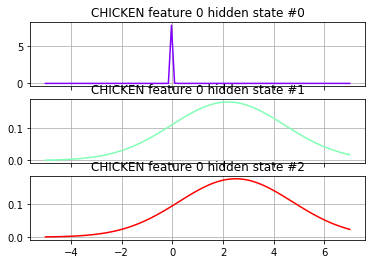

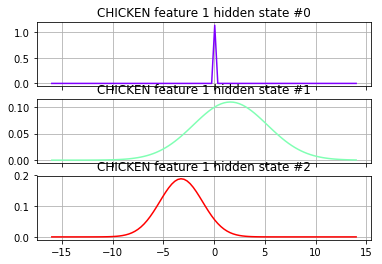

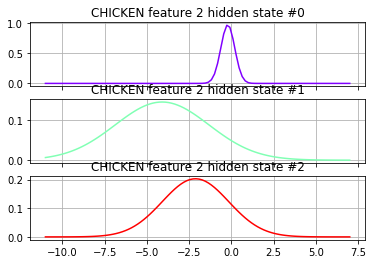

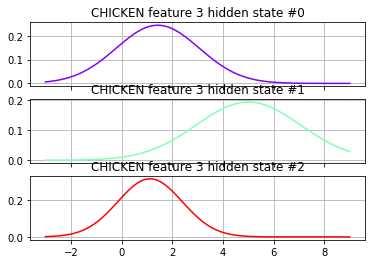

In [14]:
%matplotlib inline
import math
from matplotlib import (cm, pyplot as plt, mlab)


def visualize(word, model):
    """ visualize the input model for a particular word """
    variance = np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:, parm_idx]) - max(variance[:, parm_idx]))
        xmax = int(max(model.means_[:, parm_idx]) + max(variance[:, parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i, parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()


visualize(testword, model)

###  Model Selectors
Three methods are explored here: 

- `SelectorCV `: Log likelihood with Cross-Validation folds
- `SelectorBIC`: Baysian Information Criterion
- `SelectorDIC`: Discriminative Information Criterion

Each word in the training set will be trained with a range of values for the number of hidden states, and then scored with the model selector, choosing the "best" according to each strategy.

#### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  Only the "left out" fold is scored.  This gives us a proxy method of finding the best model to use on "unseen data". 

#### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process. [reference](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf)

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

In [15]:
import math
import statistics
import warnings

import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import KFold
from asl_recognizer.asl_utils import combine_sequences


class ModelSelector(object):
    '''
    base class for model selection (strategy design pattern)
    '''

    def __init__(self,
                 all_word_sequences: dict,
                 all_word_Xlengths: dict,
                 this_word: str,
                 n_constant=3,
                 min_n_components=2,
                 max_n_components=10,
                 random_state=14,
                 verbose=False):
        self.words = all_word_sequences
        self.hwords = all_word_Xlengths
        self.sequences = all_word_sequences[this_word]
        self.X, self.lengths = all_word_Xlengths[this_word]
        self.this_word = this_word
        self.n_constant = n_constant
        self.min_n_components = min_n_components
        self.max_n_components = max_n_components
        self.random_state = random_state
        self.verbose = verbose

    def select(self):
        raise NotImplementedError

    def base_model(self, num_states):
        # with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        # warnings.filterwarnings("ignore", category=RuntimeWarning)
        try:
            hmm_model = GaussianHMM(
                n_components=num_states,
                covariance_type="diag",
                n_iter=1000,
                random_state=self.random_state,
                verbose=False).fit(self.X, self.lengths)
            if self.verbose:
                print("model created for {} with {} states".format(self.this_word, num_states))
            return hmm_model
        except:
            if self.verbose:
                print("failure on {} with {} states".format(self.this_word, num_states))
            return None

####  Constant

In [16]:
class SelectorConstant(ModelSelector):
    """ select the model with value self.n_constant

    """

    def select(self):
        """ select based on n_constant value

        :return: GaussianHMM object
        """
        best_num_components = self.n_constant
        return self.base_model(best_num_components)

####  Log Likelihood of cross-Validation folds (CV)


In [17]:
class SelectorCV(ModelSelector):
    """ select best model based on average log Likelihood of cross-validation folds """

    def select(self):
        """ :return: GaussianHMM object """

        warnings.filterwarnings("ignore", category=DeprecationWarning)

        #  Sequences of size lower than 3 must be considered:
        if len(self.sequences) >= 3:
            n_splits = 3
        elif len(self.sequences) == 2:
            n_splits = 2
        else:
            # print("No CV possible for word: ", self.this_word, "only has 1 occurrence")
            return None

        best_score = float('-inf')  # hold the highest avg of cross-validation scores found
        best_model = None  # hold the model with the highest avg of CV score found

        # main loop: get model and score for different number of hidden states 
        #             and update best_score and best_model
        for n_components in range(self.min_n_components, self.max_n_components + 1):

            split_method = KFold(n_splits=n_splits)
            logL = []  # list of cross validation scores obtained

            # get the model for the combined cross-validation training sequences and score with
            #  their combined validation sequences filling the list 'logL'
            for cv_train_idx, cv_test_idx in split_method.split(self.sequences):

                self.X, self.lengths = combine_sequences(cv_train_idx, self.sequences)
                model = self.base_model(
                    n_components)  # avoid code duplication using the inherited method
                if model is None:  # failed
                    continue

                test_X, test_lengths = combine_sequences(cv_test_idx, self.sequences)
                try:  # hmmlearn stability issues
                    logL.append(model.score(test_X, test_lengths))
                except:
                    continue

            if model is None or logL == []:
                continue

            score = np.mean(logL)  # The higher the better
            if score > best_score:
                best_score = score
                best_model = model

        return best_model

####  Baysian Information Criterion (BIC)


In [18]:
class SelectorBIC(ModelSelector):
    """ select the model with the lowest Baysian Information Criterion(BIC) score

    http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf
    Bayesian information criteria: BIC = -2 * logL + p * logN
    """

    def select(self):
        """ select the best model for self.this_word based on
        BIC score for n between self.min_n_components and self.max_n_components
        :return: GaussianHMM object
        """
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        best_BIC = float('inf')  # hold the lowest BIC found
        best_model = None  # hold the model with the lowest BIC found

        # main loop: get model and score for different number of hidden states 
        #             and update best_BIC and best_model
        for n_components in range(self.min_n_components, self.max_n_components + 1):
            logL = None
            model = self.base_model(
                n_components)  # avoid code duplication using the inherited method
            if model is None:  # failed
                continue
            try:  # hmmlearn stability issues
                logL = model.score(self.X, self.lengths)
            except:
                continue

            # BIC = -2 log L + p log N  (the lower the better)
            # p = num free params = transistion probs(n*n) + means(n*f) + covars(n*f)  
            p = n_components**2 + (2 * len(self.X[0]) * n_components)
            BIC = -2 * logL + p * np.log(len(self.X))
            if BIC < best_BIC:
                best_BIC = BIC
                best_model = model

        return best_model

####  Discriminative Information Criterion (DIC)


In [19]:
class SelectorDIC(ModelSelector):
    """ select best model based on Discriminative Information Criterion

    Biem, Alain. "A model selection criterion for classification: Application to hmm topology 
    optimization." Document Analysis and Recognition, 2003. Proceedings. Seventh International 
    Conference on. IEEE, 2003.
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf
    DIC = log(P(X(i)) - 1/(M-1)SUM(log(P(X(all but i))
    """

    def select(self):
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        best_DIC = float('-inf')  # hold the highest BIC found
        best_model = None  # hold the model with the highest BIC found
        my_word = self.this_word  # word to evaluate

        # main loop: get model and score for different number of hidden states 
        #             and update best_DIC and best_model
        for n_components in range(self.min_n_components, self.max_n_components + 1):
            logL = None  # likelihood of the trained model
            anti_logL = []  # list containing all the anti likelihoods of the trained model
            self.this_word = my_word

            # train the model for current word (self.this_word)
            model = self.base_model(
                n_components)  # avoid code duplication using the inherited method
            if model is None:  # failed
                continue
            # get the likelihood of the model
            try:  # hmmlearn stability issues
                logL = model.score(self.X, self.lengths)
            except:
                continue

            # get the anti-likehoods (score every other word for the current model)
            for other_word in self.hwords:
                if other_word == my_word:
                    continue
                X, lengths = self.hwords[other_word]
                try:  # stability issues for hmmlearn v<0.2.1
                    anti_logL.append(model.score(X, lengths))
                except:
                    continue

            # I found the docstring formula a bit confusing: 
            # DIC = log(P(X(i)) - 1/(M-1)SUM(log(P(X(all but i)) 
            # The size of anti_logL is M-1, as the word evaluated is not included in anti_logL.
            # Biem, Alain: "DIC = Difference between the likelihood of the data an the the 
            # average of anti-likelihood"
            # From the paper we can state: DIC = log(P(X(i)) - average(log(P(X(all but i))
            DIC = logL - np.average(anti_logL)  # the higher the better
            if DIC > best_DIC:
                best_DIC = DIC
                best_model = model

        return best_model

###  Training example


In [20]:
training = asl.build_training(features_ground)
word = 'CHICKEN'
model = SelectorConstant(
    training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CHICKEN is 3


<a id='part2_submission'></a>
### Model Selectors Training

In [21]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [22]:
def train(features, model_selector):
    training = asl.build_training(features)
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = model_selector(
            sequences,
            Xlengths,
            word,
            min_n_components=2,
            max_n_components=15,
            random_state=14).select()
        end = timeit.default_timer() - start
        if model is not None:
            print("Training complete for {} with {} states with time {} seconds".format(
                word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))

In [23]:
selector = [SelectorCV, SelectorBIC, SelectorDIC]

for i in selector:
    print("{}:".format(i))
    train(features_ground, i)

<class '__main__.SelectorCV'>:
Training complete for FISH with 11 states with time 0.36364252299972577 seconds
Training complete for BOOK with 6 states with time 4.421584876999987 seconds
Training complete for VEGETABLE with 2 states with time 2.0113580120014376 seconds
Training complete for FUTURE with 2 states with time 4.179233299000771 seconds
Training complete for JOHN with 12 states with time 42.61958790699646 seconds
<class '__main__.SelectorBIC'>:
Training complete for FISH with 5 states with time 0.36513492399899405 seconds
Training complete for BOOK with 8 states with time 2.3213795779993234 seconds
Training complete for VEGETABLE with 9 states with time 0.8410732449992793 seconds
Training complete for FUTURE with 9 states with time 2.4961920649984677 seconds
Training complete for JOHN with 13 states with time 23.01789991700207 seconds
<class '__main__.SelectorDIC'>:
Training complete for FISH with 3 states with time 0.9269850839991705 seconds
Training complete for BOOK with 

Advantages and disadvantages of the model selectors implemented:

**CV**: Common in supervised learning to avoid partitioning the training set for validation. Among the tree model selectors, CV is the only one (cross)validated with sequences different from the training sets. However, the running time needed is higher than direct selectors like BIC. For each word, several models are created for cross-validation (combinations of training-validation sequences).

**BIC**: a simple selector penalizing the resulted likelihood with the complexity of the model. It reduces the risk of overfitting. The running time is lower than CV and DIC, as only one model and one score are computed per number of hidden nodes.

**DIC**: The penalty term in DIC is based on the average likelihood for the other words, thus having higher computational cost than BIC.
Further comparisons discussed together with the results of part 3 of the project


<a id='part3'></a>
## 3: Recognizer
Here we perform experiments training all the words for the 4 feature sets and the 3 model selectors.  

### Train the full training set

In [24]:
def train_all_words(features, model_selector):
    training = asl.build_training(features)
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, n_constant=3).select()
        model_dict[word] = model
    return model_dict

The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector

In [25]:
models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


### Load the test set

In [26]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


### Recognizer Implementation

In [27]:
import warnings
from asl_recognizer.asl_data import SinglesData


def recognize(models: dict, test_set: SinglesData):
    """ Recognize test word sequences from word models set

   :param models: dict of trained models
       {'SOMEWORD': GaussianHMM model object, 'SOMEOTHERWORD': GaussianHMM model object, ...}
   :param test_set: SinglesData object
   :return: (list, list)  as probabilities, guesses
       both lists are ordered by the test set word_id
       probabilities is a list of dictionaries where each key a word and value is Log Liklehood
           [{SOMEWORD': LogLvalue, 'SOMEOTHERWORD' LogLvalue, ... },
            {SOMEWORD': LogLvalue, 'SOMEOTHERWORD' LogLvalue, ... },
            ]
       guesses is a list of the best guess words ordered by the test set word_id
           ['WORDGUESS0', 'WORDGUESS1', 'WORDGUESS2',...]
   """
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    probabilities = []
    guesses = []

    test_sequences = list(
        test_set.get_all_Xlengths().values())  # extract X and Xlength lists in a variable

    # Main loop: iterate for each word sequence and fill the lists probabilities and guesses
    for test_X, test_Xlength in test_sequences:

        best_score = float(
            '-inf')  # hold the highest likelihood found for the current sequence
        best_word = None  # hold the word with the highest likelihood for the current sequence
        prob_dict = {
        }  # dictionary to fill before being added to the probabilities list {word: LogL}

        # Score the models avaliable for different words for the current sequence, 
        # fill prob_dict, and update best_score and best_word found
        for word, model in models.items():
            try:  # hmmlearn stability issues
                logL = model.score(test_X, test_Xlength)
            except:
                logL = None

            prob_dict[word] = logL
            if logL is not None:
                if logL > best_score:
                    best_score = logL
                    best_word = word

        probabilities.append(prob_dict)
        guesses.append(best_word)

    return probabilities, guesses

## Evaluation

In [29]:
from asl_recognizer.asl_utils import show_errors


def evaluate(features, model_selector):

    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    show_errors(guesses, test_set)

In [30]:
%%time
#  BASE COMBINATION:  SelectorConstant with features_ground.  WER = 0.669
evaluate(features_ground, SelectorConstant)


**** WER = 0.6685393258426966
Total correct: 59 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO                               JOHN IX THINK MARY LOVE
   43: *FRANK *GO BUY HOUSE         

In [31]:
%%time
#  COMBINATION 1:   SelectorCV with features_polar.
evaluate(features_polar, SelectorCV)


**** WER = 0.6067415730337079
Total correct: 70 out of 178
Video  Recognized                                                    Correct
    2: *POSS *BROTHER *NEW                                           JOHN WRITE HOMEWORK
    7: JOHN *HAVE GO *WHAT                                           JOHN CAN GO CAN
   12: *IX *WHAT *WHAT CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW *POSS *JOHN *CAR *CAR *VISIT *FUTURE                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *JOHN IX                                      JOHN LIKE IX IX IX
   28: JOHN *JOHN *MARY *JOHN IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIRL *GIVE *MARY *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *CORN *JOHN *IX                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [32]:
%%time
#  COMBINATION 2:  SelectorBIC with features_polar.
evaluate(features_polar, SelectorBIC)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW WONT *NOT *GIVE1 *TEACHER *FUTURE *WHO              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *WHO IX                                       JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *FUTURE1 *JOHN *MARY                              JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [33]:
%%time
#  COMBINATION 3:  SelectorCV with features_custom(delta2).
evaluate(features_custom, SelectorCV)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX *ARRIVE                                              JOHN WRITE HOMEWORK
    7: JOHN *HAVE GO *TEACHER                                        JOHN CAN GO CAN
   12: JOHN CAN *FUTURE CAN                                          JOHN CAN GO CAN
   21: JOHN *NOT *GIVE1 *JOHN *NEW *VISIT *MARY *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   36: *JOHN *MARY *IX *LIKE *MARY *JOHN                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN *JOHN *JOHN                                     JOHN IX THINK MARY LOVE
   43: JOHN *MARY *GO HOUSE         

**Results:**

| Selector | features |Word Error Rate  | wall time (s) |
|----------|----------|------|---------------|
| CV | polar | 0.607 |  119  |
| BIC | polar | 0.545 | 78   |
| CV | delta2 | 0.539 | 126 |


More tests were performed, leading to the following conclusions:

- Best combination found: SelectorCV + "delta_2" custom features
- DIC and BIC never improves 0.6 WER
- Normalized features perform worse than the rest. 
- Delta features never improves 0..6 WER (best: 0.612 with selectorCV)
- After using "delta2" custom features, we easily obtained WER lower than 0.6 for the three model selectors. It gave us a better comparison. SelectorCV had a better performance with "delta2" than BIC and DIC, just opposite to  polar features)

About the running time, BIC model selector is the fastest for all tests for the reasons discussed in part 2, followed by Cross-Validation (~1.5 times longer). We rejected DIC earlier for similar or worse performance and higher running time.

To improve WER we suggest enhancing "delta2" or "polar" with a linear function of combinations of features. Other variables like zoom and hand orientations, unavailable in this project, could help to elaborate more accurate features.

A better option is to include statistical data with information about the occurrence of a word in a sentence. We could also use the probability of the word to appear next to other words (biased priors could be created before training). By using semantics rules, for example, a heuristic strategy using previous sequences could focus the search for meaningful words. 

Moreover, as all sequences are ordered, a Recurrent Neural Network (GRU or LSTM) could be used to improve the models here.

